In [1]:
!pip install sacrebleu
!pip install bert_score

  Obtaining dependency information for sacrebleu from https://files.pythonhosted.org/packages/de/ea/025db0a39337b63d4728a900d262c39c3029b0fe76a9876ce6297b1aa6a0/sacrebleu-2.4.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 5.5 MB/s eta 0:00:00
  Obtaining dependency information for portalocker from https://files.pythonhosted.org/packages/17/9e/87671efcca80ba6203811540ed1f9c0462c1609d2281d7b7f53cef05da3d/portalocker-2.8.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 7.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from huggingface_hub import notebook_login
from datasets import load_dataset,load_metric
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
data = load_dataset("cfilt/iitb-english-hindi")
data

Downloading:   0%|          | 0.00/953 [00:00<?, ?B/s]

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/parquet/cfilt--iitb-english-hindi-2cfae92395f2614b/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    validation: Dataset({
        features: ['translation'],
        num_rows: 520
    })
    train: Dataset({
        features: ['translation'],
        num_rows: 1659083
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 2507
    })
})

In [4]:
small = data["train"].shuffle(seed=42).select(range(5_000))
split = small.train_test_split(seed=42, test_size=0.2)
split["test"][0], split["train"][0]

({'translation': {'en': 'Korean (_ ISO - 2022 - KR)',
   'hi': 'कोरियाई (_ ISO-2022-KR) '}},
 {'translation': {'en': 'A token unto them is night. We strip it of the day, and lo! they are in darkness.',
   'hi': 'और एक निशानी उनके लिए रात है। हम उसपर से दिन को खींच लेते है। फिर क्या देखते है कि वे अँधेरे में रह गए'}})

In [5]:
checkpoint = 'Helsinki-NLP/opus-mt-en-hi'
access_token = "Give Your token here"
tokenizer = AutoTokenizer.from_pretrained(checkpoint,token=access_token)

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/812k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/1.07M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/marian/tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [6]:
en_sample = split['train'][5]['translation']['en']
hi_sample = split['train'][5]['translation']['hi']

print("English : ", en_sample)
print("Hindi : ", hi_sample)

English :  e - Governance Initiative in West - Bengal
Hindi :  पश्चिम बंगाल में ई-शासन पहल


In [7]:
inputs = tokenizer(en_sample)
targets = tokenizer(text_target=hi_sample)

print("Input IDs : ", inputs['input_ids'])
print("Target IDs : ", targets['input_ids'])

Input IDs :  [2281, 32, 6107, 5418, 39301, 3447, 21, 6659, 32, 56756, 0]
Target IDs :  [7092, 855, 19661, 800, 11, 2106, 69, 11115, 7112, 7533, 0]


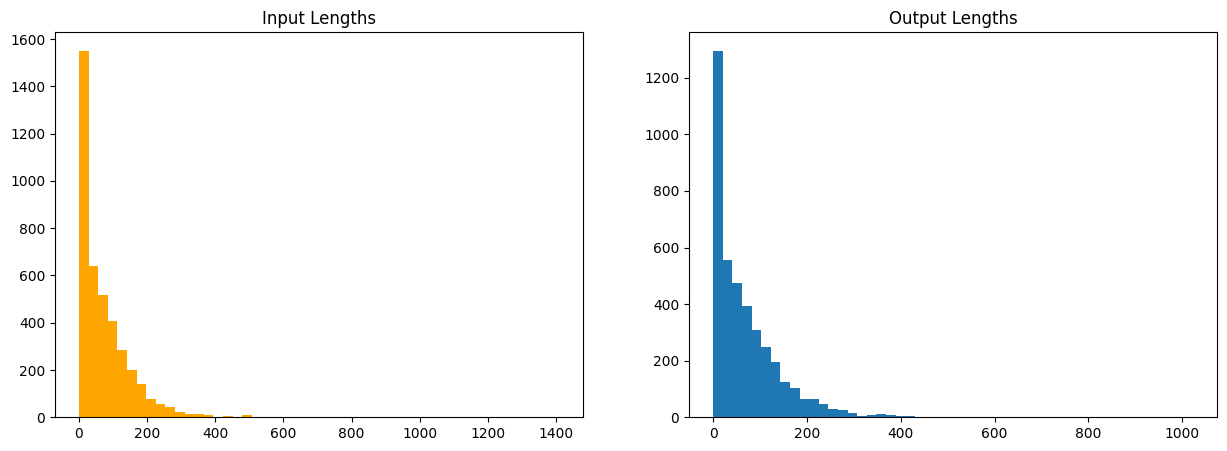

In [8]:
train = split['train']['translation']

inp_len = [len(tr['en']) for tr in train]
op_len = [len(tr['hi']) for tr in train]

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.hist(inp_len, bins=50, label='input', color='orange')
plt.title('Input Lengths')

plt.subplot(1, 2, 2)
plt.hist(op_len, bins=50, label='output')
plt.title('Output Lengths')

plt.show()

In [9]:
input_lens = pd.Series(inp_len)
output_lens = pd.Series(op_len)

print("## Input Lengths ##")
print(input_lens.describe())

print("\n## Output Lengths ##")
print(output_lens.describe())

## Input Lengths ##
count    4000.000000
mean       73.288250
std        86.971338
min         0.000000
25%        14.000000
50%        47.000000
75%       105.000000
max      1410.000000
dtype: float64

## Output Lengths ##
count    4000.00000
mean       70.48125
std        79.01160
min         0.00000
25%        14.00000
50%        47.00000
75%       101.00000
max      1024.00000
dtype: float64


In [10]:
max_inp_len = 150
max_target_len = 150

def tokenizer_fn(batch):
    inputs = [x['en'] for x in batch['translation']]
    targets = [x['hi'] for x in batch['translation']]
    
    tokenized_inputs = tokenizer(
                                inputs, 
                                max_length=max_inp_len, 
                                truncation=True
                                )

    tokenized_targets = tokenizer(
                                text_target=targets, 
                                max_length=max_target_len, 
                                truncation=True
                                )
    
    tokenizer_full = tokenized_inputs.copy()
    tokenizer_full['labels'] = tokenized_targets['input_ids']
    return tokenizer_full

In [11]:
tokenized_datasets = split.map(
                            tokenizer_fn,
                            batched=True,
                            remove_columns=split['train'].column_names,
                            )

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [12]:
def compute_metrics(
                    preds_and_labels,
                    bleu_metric = load_metric("sacrebleu"),
                    bert_metric = load_metric("bertscore")
                    ):

    preds, labels = preds_and_labels
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # for any -100 label, replace with pad token id
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    # convert labels into words
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [[label.strip()] for label in decoded_labels]

    bleu = bleu_metric.compute(
                                predictions=decoded_preds, 
                                references=decoded_labels
                                )
    bert_score = bert_metric.compute(
                                    predictions=decoded_preds, 
                                    references=decoded_labels, 
                                    lang='fr'
                                    )

    return {
            "bleu": bleu["score"], 
            'bert_score': np.mean(bert_score['f1'])
            }

In [13]:
Seq2SeqLM = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)
data_collator = DataCollatorForSeq2Seq(tokenizer, model=Seq2SeqLM)

training_args = Seq2SeqTrainingArguments(
                                        "finetuned-model",
                                        evaluation_strategy="no",
                                        save_strategy="epoch",
                                        learning_rate=2e-5,
                                        per_device_train_batch_size=8,
                                        per_device_eval_batch_size=4,
                                        weight_decay=0.01,
                                        save_total_limit=3,
                                        num_train_epochs=3,
                                        predict_with_generate=True
                                        )

trainer = Seq2SeqTrainer(
                        Seq2SeqLM,
                        training_args,
                        train_dataset=tokenized_datasets["train"],
                        eval_dataset=tokenized_datasets["test"],
                        data_collator=data_collator,
                        tokenizer=tokenizer,
                        compute_metrics=compute_metrics,
                    )

pytorch_model.bin:   0%|          | 0.00/306M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

In [14]:
trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss
500,3.363100
1000,2.965000
1500,2.744300


TrainOutput(global_step=1500, training_loss=3.02413671875, metrics={'train_runtime': 262.6671, 'train_samples_per_second': 45.685, 'train_steps_per_second': 5.711, 'total_flos': 154387984416768.0, 'train_loss': 3.02413671875, 'epoch': 3.0})

In [15]:
trainer.evaluate(max_length=max_target_len)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

{'eval_loss': 2.9524807929992676,
 'eval_bleu': 29.01245762819078,
 'eval_bert_score': 0.8203314924240113,
 'eval_runtime': 123.924,
 'eval_samples_per_second': 8.069,
 'eval_steps_per_second': 2.017,
 'epoch': 3.0}

In [18]:
trainer.save_model("/kaggle/working/HF_NMT_FINETUNED")

In [19]:
from transformers import pipeline
translator = pipeline("translation", model='/kaggle/working/HF_NMT_FINETUNED', device=-1)

/opt/conda/lib/python3.10/site-packages/transformers/models/marian/tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [20]:
translator("This is a testing model !", max_length=128)

[{'translation_text': 'यह एक परीक्षण मॉडल है!'}]